# **Image Captions Generation with Neural Networks**

This notebook would attempt to build a image captioning model by encoding the image using Xception model and decode it using a multi-layer Neural Network Model.

**Contents:**

**1. Importing Libraries and Dataset**

**2. Analysing and Processing Images**

**3. Analysing and Processing Captions**

**4. Combining Images and Captions data**

**5. Training the Model**

**6. Results and Examples**

# **1. Importing Libraries and Dataset**

In [1]:
from google.colab import drive


drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#set directory
direc = '<insert directory>'

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import OrderedDict
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))



python 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
keras version 2.2.4
tensorflow version 1.12.0


Using TensorFlow backend.


In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
# Insert location of the Flickr30K_ photos
dir_Flickr_jpg = direc + "flickr30k_images/"
# Insert Location of the caption file
dir_Flickr_text = direc + "flick30ktext.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("Number of Images in Flicker30k dataset: {}".format(len(jpgs)))

Number of Images in Flicker30k dataset: 32624


In [6]:
#Read caption data and convert them into dataframe
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):  #get each line
    col = line.split('\t')
    if len(col) == 1:  #if there is nothing
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uniq_filenames = np.unique(df_txt.filename.values)
print("Number of unique file names : {}".format(len(uniq_filenames)))
print("Number of captions for each image : Number of Images ---> "+str(Counter(Counter(df_txt.filename.values).values())))

Number of unique file names : 31783
Number of captions for each image : Number of Images ---> Counter({5: 31783})


In [7]:
df_txt.head()

,filename,index,caption
0,1000092795.jpg,0,two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"two young , white males are outside near many ..."
2,1000092795.jpg,2,two men in green shirts are standing in a yard .
3,1000092795.jpg,3,a man in a blue shirt standing in a garden .
4,1000092795.jpg,4,two friends enjoy time spent together .


**Let's look at the captions for 5 random pictures.**

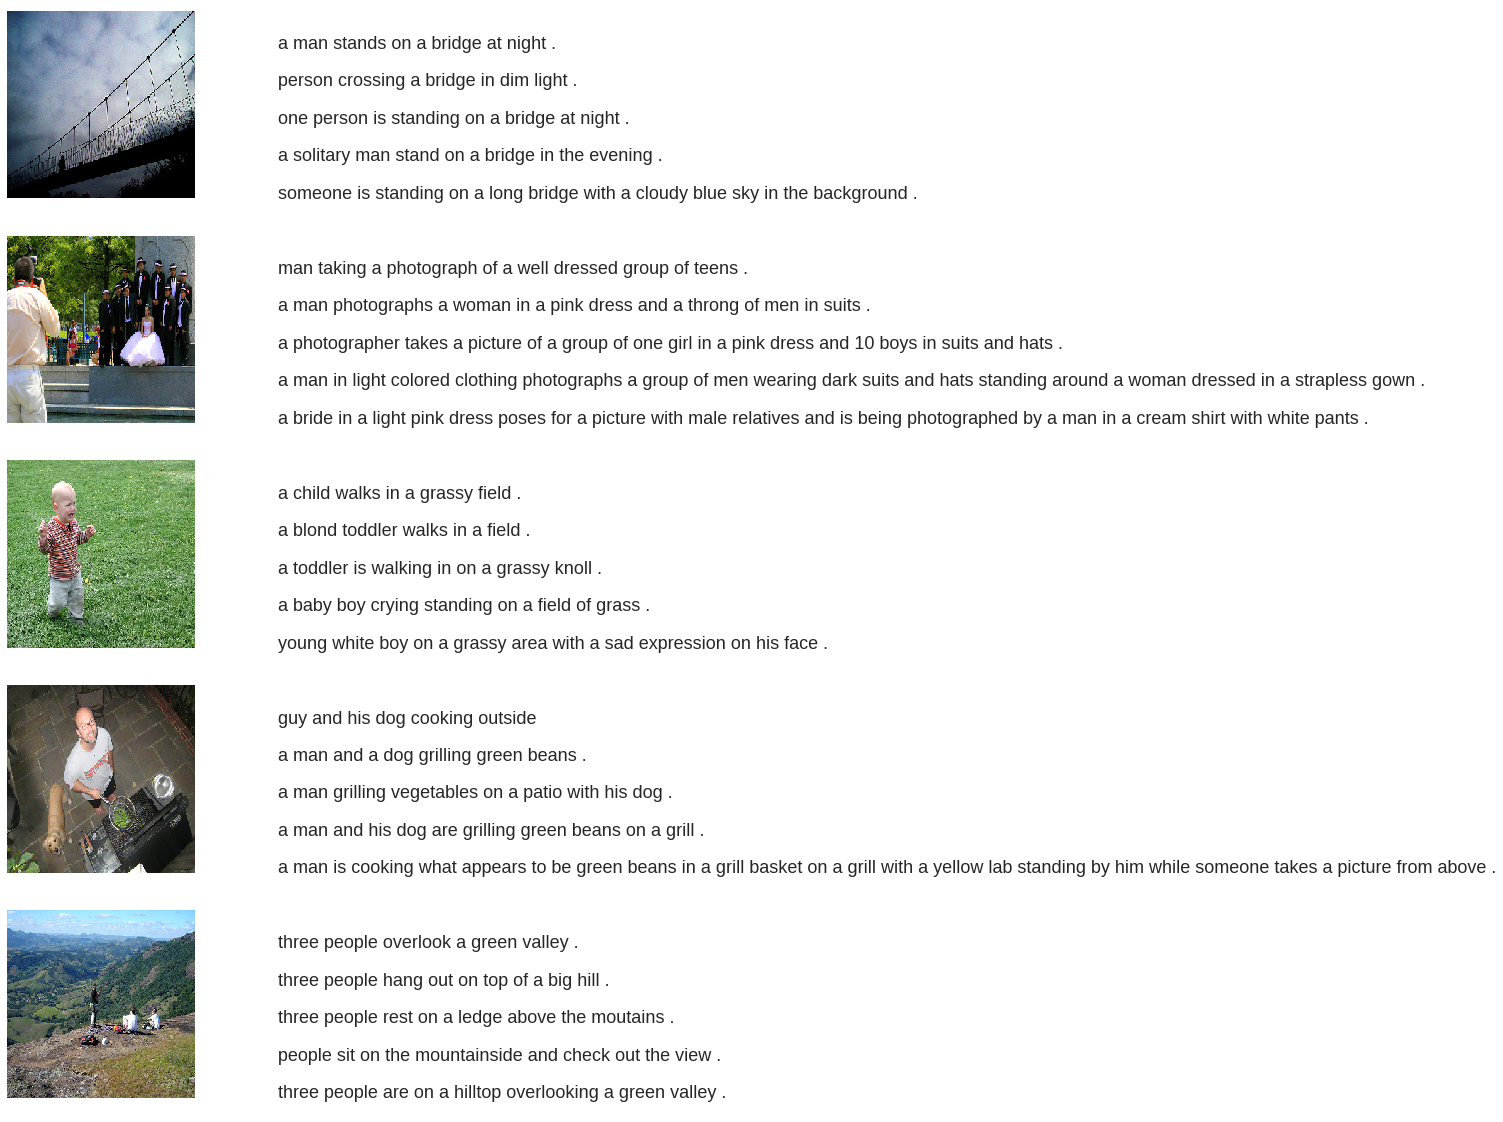

In [8]:
from keras.preprocessing.image import load_img, img_to_array

num_pics = 5
num_pixels = 299  #set to 299 because we are using xception model later which takes in 299*299*3 as the input for images

target_size = (num_pixels,num_pixels,3)

count = 1
fig = plt.figure(figsize=(10,20))
for filenm in uniq_filenames[123:123+num_pics]:
    filename = dir_Flickr_jpg + '/' + filenm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==filenm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(num_pics,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(num_pics,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=18)
    count += 1
plt.show()

# **2. Analysing and Processing Images**

**We would use the pre-trained Xception Model to extract the features from our images**

In [9]:
from keras.applications import Xception
xception_model = Xception(include_top=True)
xception_model.load_weights(direc + "xception_weights_tf_dim_ordering_tf_kernels.h5")
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

**We would remove the last layer of the model as we are extracting features and not making classification predictions. Hence, we would use the last hidden layer of the Xception model as the output --> features of our images**

In [10]:
from keras import models
xception_model.layers.pop()  #remove last layer
xception_model = models.Model(inputs=xception_model.inputs, outputs=xception_model.layers[-1].output)
# show the model
xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

**We will process all the images and save them in a pickle file. This has been done already to save time (hence code commented out)**

In [11]:
from tqdm import tqdm
from keras.applications.xception import preprocess_input
'''
images = OrderedDict()
for i,name in enumerate(jpgs):
    # load an image from file
    filename = dir_Flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    
    y_pred = xception_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()
    if i>=999 and i%1000 == 0:
        print(str(i) + " done")
'''

'\nimages = OrderedDict()\nfor i,name in enumerate(jpgs):\n    # load an image from file\n    filename = dir_Flickr_jpg + \'/\' + name\n    image = load_img(filename, target_size=target_size)\n    # convert the image pixels to a numpy array\n    image = img_to_array(image)\n    nimage = preprocess_input(image)\n    \n    y_pred = xception_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))\n    images[name] = y_pred.flatten()\n    if i>=999 and i%1000 == 0:\n        print(str(i) + " done")\n'

In [12]:
#load the processed images file
import pickle
pkl_file = open(direc+'30kimages.pkl', 'rb')
images = pickle.load(pkl_file)
pkl_file.close()

len(images)

31783

**Let's apply PCA and observe some images from the clusters**

In [ ]:

from sklearn.decomposition import PCA
img_val=[]
for i in images.values():
    img_val.append(i)
encoder = np.array(img_val)
pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)


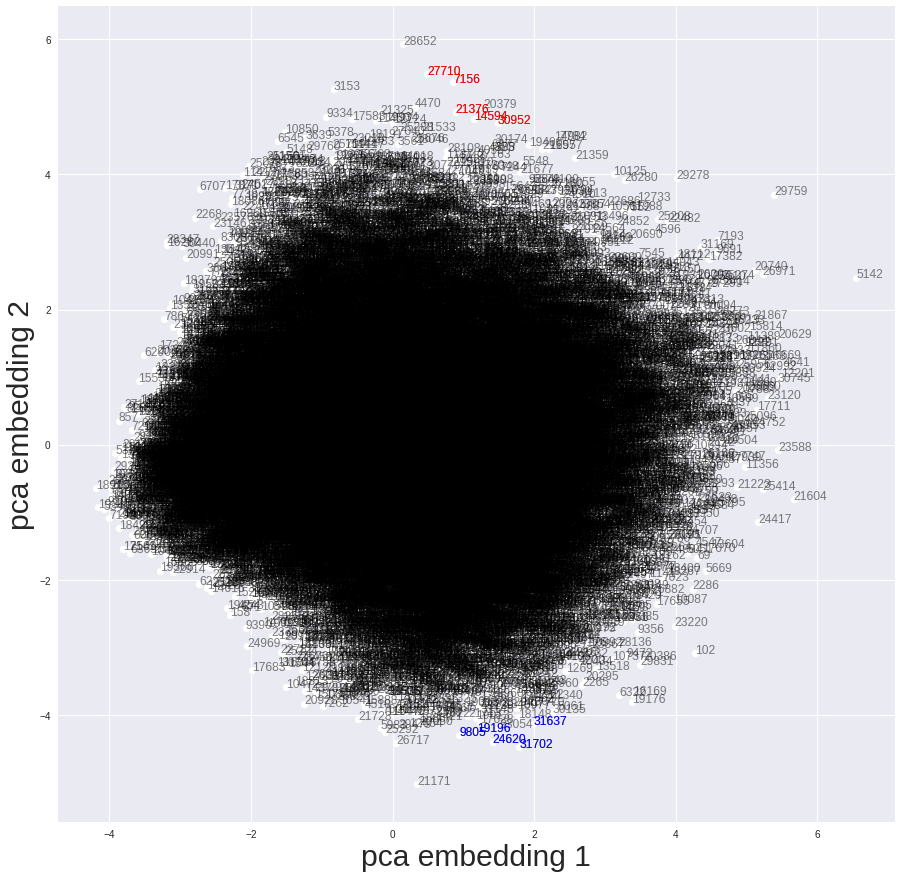

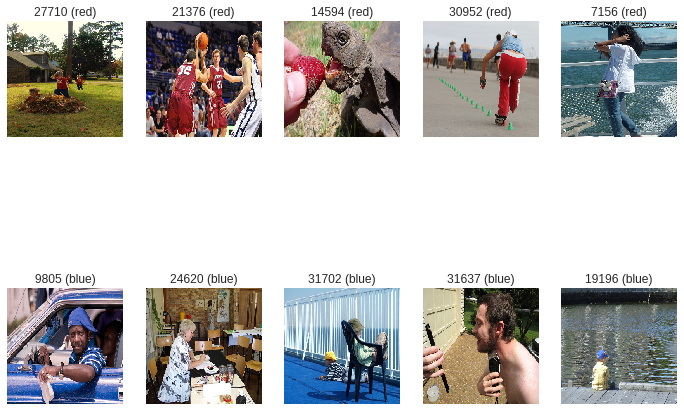

In [14]:

#selected pictures that are creating clusters
picked_pic = OrderedDict()
picked_pic["red"]     = [27710,21376,14594,30952,7156]
picked_pic["blue"]    = [9805,24620,31702,31637,19196]



fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images 
fig = plt.figure(figsize=(12,9))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
    
        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

**We can see that PCA does cluster them relatively well:**

**- red clusters: People caught in mid-air**

**- blue clusters: Group of people sitting down at a table**






# **3. Analysing and Processing Captions**

In [15]:
#get a dataframe of words used
def df_word(df_txt):
    vocab = []
    for txt in df_txt.caption.values:
        vocab.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocab)) + ' unique words')
    ct = Counter(vocab)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(5)

Vocabulary Size: 20324 unique words


,word,count
0,a,271698
1,.,151039
2,in,83466
3,the,62978
4,on,45669


**Let's visualise the top 20 most frequently appearing words as well as the bottom 20**

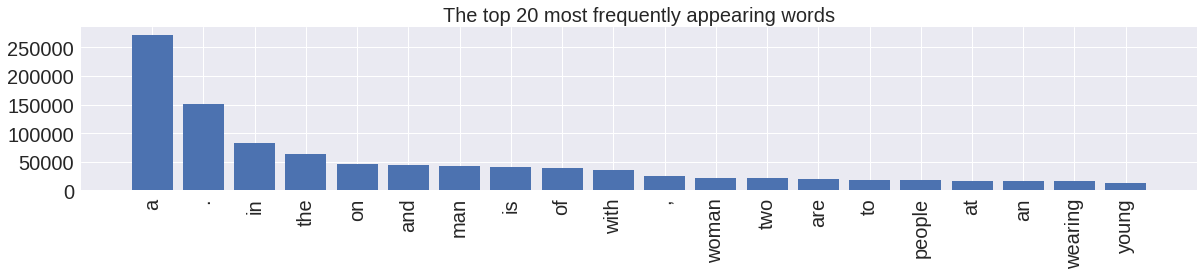

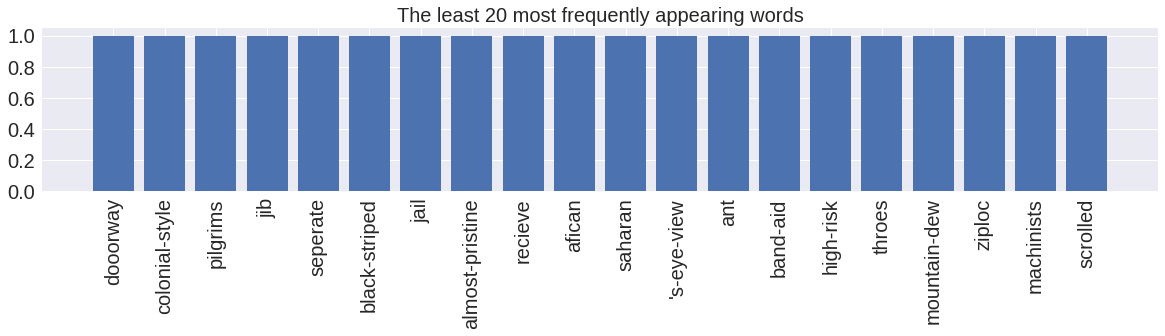

In [16]:
topn = 20

def plthist(dfsub,title):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 20 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 20 most frequently appearing words")

**We shall remove punctuations,' numerical' words (e.g 5) and single-character words to clean up and reduce our vocabulary memory.**

In [ ]:
import string
def remove_punctuation(text_original):
    return ''.join(c for c in text_original if c not in string.punctuation)
def remove_single_character(text):
    len_more_than_one= ""
    for word in text.split():
        if len(word) > 1:
            len_more_than_one+= " " + word
    return(len_more_than_one)
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        if word.isalpha()  :
            text_no_numeric += " " + word
    return(text_no_numeric)


In [18]:

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
'''
for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption
'''

'\nfor i, caption in enumerate(df_txt.caption.values):\n    newcaption = text_clean(caption)\n    df_txt["caption"].iloc[i] = newcaption\n'

In [ ]:
from copy import copy
'''
def add_start_end(captions):
    caps = []
    for txt in captions:
        txt = 'startcap ' + txt + ' endcap'
        caps.append(txt)
    return(caps)
txt_data = copy(df_txt)
txt_data["caption"] = add_start_end(df_txt["caption"])
txt_data.head(5)
'''
del df_txt


**Captions data has also been processed saved into a csv file to save time too**

In [ ]:
#txt_data.to_csv(direc + '30ktxt_data.csv',index=False)

In [ ]:
txt_data = pd.read_csv(direc + '30ktxt_data.csv')

In [22]:
txt_data.shape

(158915, 3)

**We would only use captions that have total words length of less than 35 in order to save space**

In [23]:
txt_data['ls'] = txt_data['caption'].str.split()
txt_data['ls'] = txt_data['ls'].apply(lambda x: len(list(x)))
txt_data=txt_data[txt_data['ls']<=35]  
txt_data.shape

(158584, 4)

# **4. Combining Images and Captions Data**

**Due to computational limitations, we would only use 10001 images/captions and only the 1st caption out of the 5 to train the model**

In [ ]:
df_images, keepindex = [],[]
txt_data = txt_data.loc[txt_data["index"].values == 0,:]  #use only the 1st caption instead of all 5 captions for simplicity sake
txt_data = txt_data.reset_index()
txt_data = txt_data.loc[:10000,:] #use 10001 due to computational limitations
for i, flnm in enumerate(txt_data.filename):
    if flnm in images.keys():
        df_images.append(images[flnm])
        keepindex.append(i)
        
fnames = txt_data["filename"].iloc[keepindex].values
df_captions = txt_data["caption"].iloc[keepindex].values
df_images = np.array(df_images)

In [25]:
txt_data.shape

(10001, 5)

**Tokenizing the words**

In [26]:
from keras.preprocessing.text import Tokenizer
# maximum number of words in dictionary
nb_words = 7000
tokenizer = Tokenizer(num_words = nb_words,oov_token='<unk>')  #replace the least common words with '<unk>'
tokenizer.fit_on_texts(df_captions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
df_token_texts = tokenizer.texts_to_sequences(df_captions)
print(df_token_texts[:5])

vocabulary size : 7481
[[2, 19, 24, 513, 7, 2096, 98, 156, 23, 72, 143, 21, 340, 78, 4, 5, 385, 3], [2, 105, 37, 4, 259, 222, 17, 1180, 800, 2097, 2098, 3], [2, 55, 4, 83, 107, 9, 214, 52, 350, 10, 480, 4, 22, 2099, 570, 3], [2, 276, 4, 20, 16, 6, 51, 9, 30, 8, 2100, 6, 335, 191, 217, 3], [2, 19, 37, 33, 4, 87, 16, 33, 4, 18, 16, 30, 97, 937, 3]]


# **5. Training the Model**


**I would split the dataset into:**

*   **8000 training images/captions**
*   **1001 validation images/captions**
*   **1000 test images/captions**






In [27]:

from sklearn.model_selection import train_test_split
combined = []
for i in range(len(fnames)):
    combined.append((fnames[i],df_token_texts[i],df_images[i]))
train,test = train_test_split(combined,test_size = 0.2,random_state = 0)
test,val = train_test_split(test,test_size = 0.5 ,random_state = 0)
len(train),len(val), len(test)

(8000, 1001, 1000)

In [ ]:
fnames_train = np.array(list(x[0] for x in train))
fnames_test = np.array(list(x[0] for x in test))
fnames_val = np.array(list(x[0] for x in val))
df_captions_train = np.array(list(x[1] for x in train))
df_captions_test = np.array(list(x[1] for x in test))
df_captions_val = np.array(list(x[1] for x in val))
df_images_train = np.array(list(x[2] for x in train))
df_images_test = np.array(list(x[2] for x in test))
df_images_val = np.array(list(x[2] for x in val))

In [29]:
#maximum length of a caption
maxlen = np.max([len(text) for text in df_token_texts])
maxlen

35

In [30]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(df_texts,df_images):
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(df_texts,df_images):
        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]   #input, output
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)

#the preprocessed data has also been saved already

''''
#Xtext_train, Ximage_train, ytext_train = preprocessing(df_captions_train,df_images_train)
Xtext_val, Ximage_val, ytext_val = preprocessing(df_captions_val,df_images_val)

#np.savez(direc+'30kXtext_train1.npy', Xtext_train)
#np.savez(direc+'30kXimage_train1.npy', Ximage_train)
#np.savez(direc+'30kytext_train1.npy', ytext_train)
np.savez(direc+'30kXtext_val1.npy', Xtext_val)
np.savez(direc+'30kXimage_val1.npy', Ximage_val)
np.savez(direc+'30kytext_val1.npy', ytext_val)


'''

"'\n#Xtext_train, Ximage_train, ytext_train = preprocessing(df_captions_train,df_images_train)\nXtext_val, Ximage_val, ytext_val = preprocessing(df_captions_val,df_images_val)\n\n#np.savez(direc+'30kXtext_train1.npy', Xtext_train)\n#np.savez(direc+'30kXimage_train1.npy', Ximage_train)\n#np.savez(direc+'30kytext_train1.npy', ytext_train)\nnp.savez(direc+'30kXtext_val1.npy', Xtext_val)\nnp.savez(direc+'30kXimage_val1.npy', Ximage_val)\nnp.savez(direc+'30kytext_val1.npy', ytext_val)\n\n\n"

In [ ]:
Xtext_train = np.load(direc+'30kXtext_train1.npy.npz')['arr_0']
Ximage_train = np.load(direc+'30kXimage_train1.npy.npz')['arr_0']
ytext_train = np.load(direc+'30kytext_train1.npy.npz')['arr_0']
Xtext_val = np.load(direc+'30kXtext_val1.npy.npz')['arr_0']
Ximage_val = np.load(direc+'30kXimage_val1.npy.npz')['arr_0']
ytext_val = np.load(direc+'30kytext_val1.npy.npz')['arr_0']

In [32]:
Xtext_train.shape,Ximage_train.shape,ytext_train.shape,Xtext_val.shape,Ximage_val.shape,ytext_val.shape

((127470, 35),
 (127470, 2048),
 (127470, 7481),
 (15869, 35),
 (15869, 2048),
 (15869, 7481))

In [33]:
from keras import layers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import merge,LSTM, Embedding,BatchNormalization, Dropout, TimeDistributed, Dense, RepeatVector, Activation, Flatten,Concatenate,CuDNNGRU
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional

dim_embedding = 256
units=512

#image
input_image = layers.Input(shape=(Ximage_train.shape[1],))
image_feat = layers.Dense(dim_embedding, input_shape=(Ximage_train.shape[1],), activation='relu',name='Img_Input_Layer')(input_image)
image_feat = layers.RepeatVector(maxlen,name='Duplicate_Layers')(image_feat)

#captions
input_txt = layers.Input(shape=(maxlen,))
txt_feat = layers.Embedding(vocab_size,dim_embedding ,input_length=maxlen, name='Txt_Input_Layer')(input_txt)
txt_feat = layers.CuDNNGRU(units, return_sequences=True, return_state=False, recurrent_initializer='glorot_uniform',name='GRU_for_txt')(txt_feat)
txt_feat = layers.LSTM(units=256,return_sequences=True,name='LSTM_for_txt')(txt_feat)

# combined txt and image into the decoder part of the framework
decoder = layers.concatenate([txt_feat,image_feat])
decoder = layers.CuDNNGRU(units, return_sequences=True, return_state=False, recurrent_initializer='glorot_uniform',name='GRU_for_decoder')(decoder)
decoder =layers.LSTM(1024,return_sequences=False,name='LSTM_for_decoder')(decoder)
output = layers.Dense(vocab_size,name='Last_Layer')(decoder)
output =layers.BatchNormalization()(output)
output =layers.Activation('softmax',name='Softmax_Activation')(output)
model = models.Model(inputs=[input_image, input_txt],outputs=output)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
Txt_Input_Layer (Embedding)     (None, 35, 256)      1915136     input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
GRU_for_txt (CuDNNGRU)          (None, 35, 512)      1182720     Txt_Input_Layer[0][0]            
__________________________________________________________________________________________________
Img_Input_

**Save our model**

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file=direc+'model_viz.png',show_shapes=True, show_layer_names=True)

**Training our model**

In [63]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.00001)
stop = EarlyStopping(monitor='val_loss', patience=3,baseline=None, restore_best_weights=True)
# fit model
batch_size = 64
start = time.time()
checkpoint = ModelCheckpoint(direc + 'weights_1.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=15, verbose=1,
                  batch_size = batch_size,
                  validation_data=([Ximage_val, Xtext_val], ytext_val),
                  callbacks=[learning_rate_reduction,checkpoint,stop])
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Train on 127470 samples, validate on 15869 samples
Epoch 1/15
127470/127470 [==============================] - 701s 6ms/step - loss: 6.1896 - acc: 0.1650 - val_loss: 4.9487 - val_acc: 0.2205

Epoch 00001: val_loss improved from inf to 4.94874, saving model to /content/drive/My Drive/Image Captioning/Automated_Image_Captioning/weights_1.hdf5
Epoch 2/15
127470/127470 [==============================] - 698s 5ms/step - loss: 4.6098 - acc: 0.2329 - val_loss: 4.5235 - val_acc: 0.2371

Epoch 00002: val_loss improved from 4.94874 to 4.52345, saving model to /content/drive/My Drive/Image Captioning/Automated_Image_Captioning/weights_1.hdf5
Epoch 3/15
127470/127470 [==============================] - 696s 5ms/step - loss: 4.1581 - acc: 0.2565 - val_loss: 4.4132 - val_acc: 0.2430

Epoch 00003: val_loss improved from 4.52345 to 4.41316, saving model to /content/drive/My Drive/Image Captioning/Automated_Image_Captioning/weights_1.hdf5
Epoch 4/15
127470/127470 [==============================] - 698s 

# **6. Results and Examples**

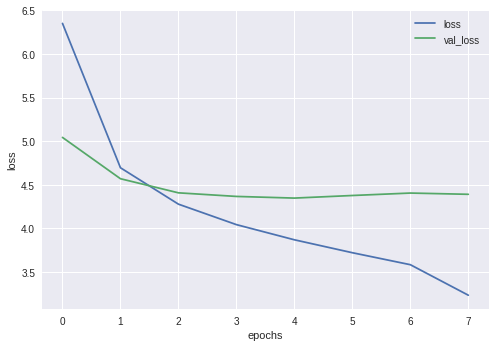

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**Calculate BLEU for our model**

In [35]:
import re, math
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu
import nltk
from keras.preprocessing.sequence import pad_sequences
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
model.load_weights(direc + "weights_1.hdf5")
def predict_caption(image):

    in_text = 'startcap'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endcap":
            break
    return(in_text)

result_test= []

def get_results(filenames,images,captions):
    result = []
    count=0
    for jpgfnm, img_feature, tokenized_text in zip(filenames,images,captions):

        count += 1
        if count % (len(filenames)//10) == 0:
            print("Processing {:4.2f}% is done..".format(100*count/float(len(filenames))))

        caption_true = [index_word[i] for i in tokenized_text]     
        caption_true = caption_true[1:-1] # remove start and end token
        #predict captions
        caption = predict_caption(img_feature.reshape(1,len(img_feature))) 
        caption = caption.split()
        caption = caption[1:-1]# remove start and end token

        bleu = sentence_bleu([caption_true],caption)
        result.append((bleu,jpgfnm,caption_true,caption))
    return result

result_train = get_results(fnames_train,df_images_train,df_captions_train)
result_val = get_results(fnames_val,df_images_val,df_captions_val)
result_test = get_results(fnames_test,df_images_test,df_captions_test)
print("Mean Training Set BLEU Score {:4.3f}".format(np.mean(list(x[0] for x in result_train))))
print("Mean Validation Set BLEU Score {:4.3f}".format(np.mean(list(x[0] for x in result_val))))
print("Mean Test Set BLEU Score {:4.3f}".format(np.mean(list(x[0] for x in result_test))))


Processing 10.00% is done..
Processing 20.00% is done..
Processing 30.00% is done..
Processing 40.00% is done..
Processing 50.00% is done..
Processing 60.00% is done..
Processing 70.00% is done..
Processing 80.00% is done..
Processing 90.00% is done..
Processing 100.00% is done..
Processing 9.99% is done..
Processing 19.98% is done..
Processing 29.97% is done..
Processing 39.96% is done..
Processing 49.95% is done..
Processing 59.94% is done..
Processing 69.93% is done..
Processing 79.92% is done..
Processing 89.91% is done..
Processing 99.90% is done..
Processing 10.00% is done..
Processing 20.00% is done..
Processing 30.00% is done..
Processing 40.00% is done..
Processing 50.00% is done..
Processing 60.00% is done..
Processing 70.00% is done..
Processing 80.00% is done..
Processing 90.00% is done..
Processing 100.00% is done..
Mean Training Set BLEU Score 0.418
Mean Validation Set BLEU Score 0.427
Mean Test Set BLEU Score 0.431


In [ ]:
def create_str(caption_true):
    strue = ""
    for s in caption_true:
        strue += " " + s
    return(strue)
def plot_images(ls):

    npix = 299
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(ls)
    for pb in ls:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.9,"Actual Caption:" + caption_true,fontsize=14)
        ax.text(0,0.7,"Predicted Caption:" + caption,fontsize=14)
        ax.text(0,0.3,"BLEU score: {}".format(round(bleu,3)),fontsize=14)
        count += 1
    plt.show()

result_test = sorted(result_test, reverse=False, key=lambda x: x[0])


Good Caption


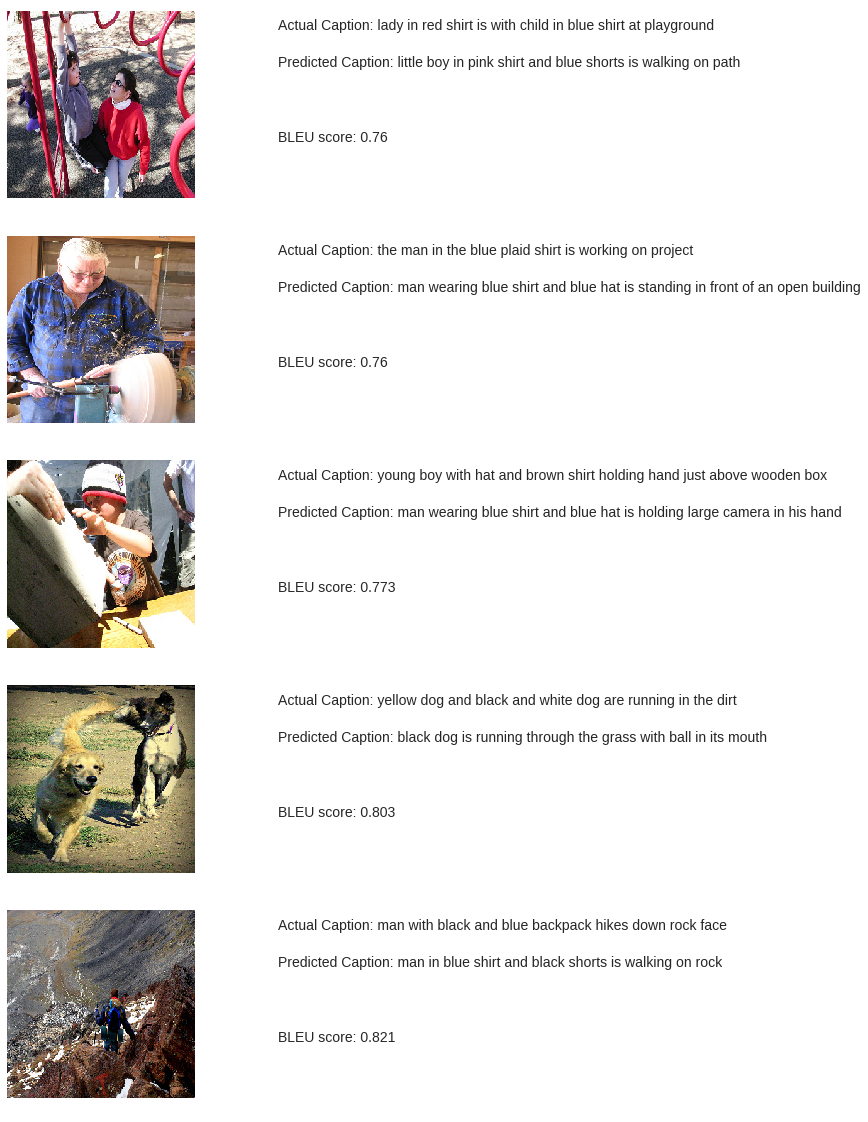

In [37]:
bad_pred = result_test[:3]
good_pred = result_test[-5:]
print("Good Caption")
plot_images(good_pred)

Bad Caption


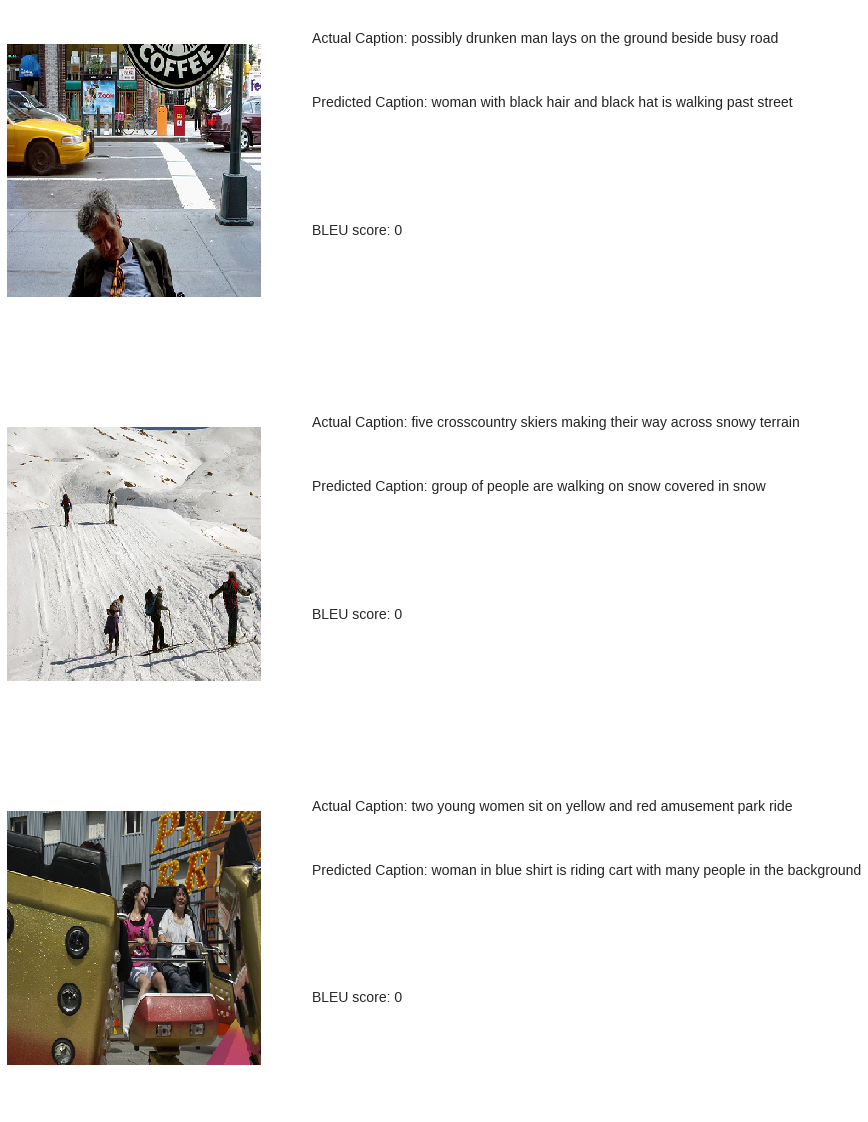

In [38]:
print("Bad Caption")
plot_images(bad_pred)

**Predict other Images**

In [ ]:
def caption_generation(image_file):
    in_text = 'startcap'
    image = load_img(image_file, target_size=target_size)
    image = img_to_array(image)
    nimage = preprocess_input(image)
    y_pred = xception_model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    image = y_pred.flatten()
    img_feature = len(image)
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image.reshape(1,img_feature),sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endcap":
            break
    caption = in_text.split()
    caption = caption[1:-1]# remove start and end token
    return create_str(caption)
       


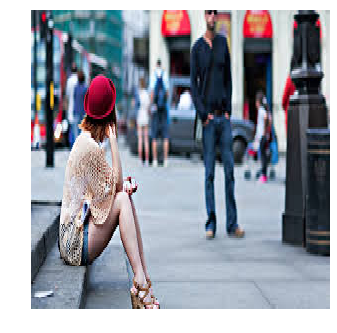

caption generated:  woman in black shirt and black shorts walks past the woman in the black shirt and black shorts


In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(load_img(direc+'/images/image.jpg', target_size=target_size))
plt.axis('off')
plt.show()

print('caption generated: ' + caption_generation(direc+'/images/image.jpg'))